# LungSeparation Model using RetinaNet

### Required Imports

In [2]:
import numpy as np
import pandas as pd

#OS utilities
import os
from os import listdir
from os.path import isfile, join

#Plotting Libraries
import matplotlib.pyplot as plt

#Image Transformation libraries
import cv2
from PIL import Image

#Imports to get pre-trained weights
import requests
import urllib

#RetinaNet Imports
from keras_retinanet.utils.visualization import draw_box, draw_caption , label_color
from keras_retinanet.utils.image import preprocess_image, resize_image
from keras_retinanet import models

#Metrics
import tensorflow as tf

### Convert YOLO format to RetinaNet format

In [2]:
def Yolo2RetinaNetXY(image_path,x_center,y_center,width,height):
    im = Image.open(image_path)
    img_width,img_height=im.size
    img_size = [img_height, img_width,1]
    
    #Below code is taken from https://github.com/tzutalin/labelImg/blob/master/libs/yolo_io.py
    x_min = max(float(x_center) - float(width) / 2, 0)
    x_max = min(float(x_center) + float(width) / 2, 1)
    y_min = max(float(y_center) - float(height) / 2, 0)
    y_max = min(float(y_center) + float(height) / 2, 1)

    x_min = int(img_size[1] * x_min)
    x_max = int(img_size[1] * x_max)
    y_min = int(img_size[0] * y_min)
    y_max = int(img_size[0] * y_max)
    
    return x_min, y_min, x_max, y_max

### Helper Function to show Bounding Box

In [3]:
def show_bounding_box(img_file,xmin,ymin,xmax,ymax):
    #im = np.array(Image.open(img_file))
    im=cv2.imread(img_file) 
    #remove alpha channel for png image
    im = im[:,:,:3]
        
    box = [xmin,ymin,xmax,ymax]
    draw_box(im, box, color=(255, 0, 0))

    plt.axis('off')
    plt.imshow(im)
    plt.show()                    

### Construct Dataset format for RetinaNet

In [4]:
def build_RetinaNet_df(annotPath):
    dataset=pd.DataFrame(columns=['fileName','xmin','ymin','xmax','ymax','class'])
    allfiles = [f for f in listdir(annotPath) if (isfile(join(annotPath, f)) & f.endswith(".txt"))]
    for file in allfiles:
        for line in open(annotPath+file,"r"):
            #print("{} :{}".format(file,line))
            img_file=(annotPath+file).replace(".txt",".png")
            coordinates=line.split()
            x_center=coordinates[1]
            y_center=coordinates[2]
            width=coordinates[3]
            height=coordinates[4]
            x_min,y_min,x_max,y_max=Yolo2RetinaNetXY(img_file,x_center,y_center,width,height)
            #show_bounding_box(img_file,x_min,y_min,x_max,y_max)
            dataset=dataset.append({'fileName': img_file, 'xmin': x_min, 'ymin':y_min,'xmax':x_max,'ymax':y_max,'class':'lungs'}, ignore_index=True)        
    return dataset

In [5]:
if (not os.path.isfile('LungSeparatorData.csv')):
    annotPath='Datasets/Lung Separator Model/'
    dataset=build_RetinaNet_df(annotPath)
    dataset.to_csv('LungSeparatorData.csv',index=False)
    dataset.head(5)

### Test the Bounding Box Function

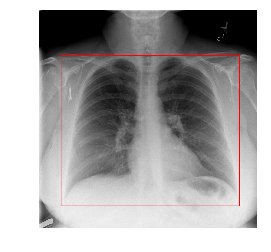

In [6]:
test_img='Datasets/Lung Separator Model/00001559_000.png'
show_bounding_box(test_img,103, 213, 942, 920)

### Create the CSV files for classes and SNAPSHOT directory to save models per epoch

In [7]:
#Define labels & write them in a file
if (not os.path.isfile('LungSeparatorClass.csv')):
    classes = ['lungs']
    with open('LungSeparatorClass.csv', 'w') as f:
        for i, class_name in enumerate(classes):
            f.write(f'{class_name},{i}\n')         

    if not os.path.exists('snapshots'):
        os.mkdir('snapshots')

### Get the Pre-trained weights for RESNET50 backbone model

In [8]:
MODEL_URL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(MODEL_URL, "PRETRAINED_MODEL")

('PRETRAINED_MODEL', <http.client.HTTPMessage at 0x7feab8365e48>)

### Shell Command to train the RetinaNet for custom dataset

python keras-retinanet/keras_retinanet/bin/train.py --freeze-backbone  --random-transform --weights PRETRAINED_MODEL --batch-size 40 --steps 51  --epochs 30  csv LungSeparatorData.csv LungSeparatorClass.csv

### Calculate IOU 

In [11]:
def compute_iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    Arguments:
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """

    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = (yi2 - yi1) * (xi2 - xi1)

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area

    # compute the IoU
    iou = inter_area / union_area

    return iou

### Helper Function to plot the bounding box on Prediction

In [4]:
def predict(img_file,orig_box,model,threshold=0.3,display=False,orig=False):
    im = np.array(cv2.imread(img_file))
    
    # if there's a PNG it will have alpha channel
    im = im[:,:,:3]

    imp = preprocess_image(im)
    imp, scale = resize_image(im)
    
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(imp, axis=0))
    
    # standardize box coordinates
    boxes /= scale

    # loop through each prediction for the input image
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < threshold:
            print("Image: {}    Score:{:.5f}".format(img_file,score))
            break

    box = box.astype(np.int32)
    color = label_color(label)
    if orig:
        draw_box(im,orig_box,color=(255,0,0)) #Original Bounded Box
    draw_box(im, box, color=color) #Prediction

    class_name = 'lungs'
    caption = f"{class_name} {score:.5f}"
    draw_caption(im, box, caption)
    score, label=score, label
    #plt.axis('off')
    img = Image.fromarray(im)
    img.save(img_file.replace(".jpg","_prediction.jpg"))
    if display:
        plt.imshow(im)
    return compute_iou(orig_box,box)
    #plt.imshow(im)
    #plt.show()
    #plt.rcParams['figure.figsize'] = [20, 10]

### Load the model trained for 30 epochs

In [8]:
model_path='resnet50_csv_30.h5'
model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

### Construct the dataframe for Testing

In [72]:
if (not os.path.isfile('LungSeparatorDataTest.csv')):
    lsmPath='Datasets/LSM_Test/'
    dataset_test=build_RetinaNet_df(lsmPath)
    dataset_test.to_csv('LungSeparatorDataTest.csv',index=False)
    dataset_test.head(5)

In [75]:
dataset_test.head(5)

,fileName,xmin,ymin,xmax,ymax,class
0,Datasets/LSM_Test/00002059_005.png,48,35,914,682,lungs
1,Datasets/LSM_Test/00002055_002.png,0,78,1023,743,lungs
2,Datasets/LSM_Test/00002054_002.png,151,76,939,837,lungs
3,Datasets/LSM_Test/00002053_000.png,185,201,756,783,lungs
4,Datasets/LSM_Test/00002059_011.png,66,161,968,833,lungs


### Predictions with bounding box

In [104]:
iou_all=[]
for row in dataset_test.values:
    img_file=row[0]
    orig_box=[row[1],row[2],row[3],row[4]]
    iou=predict(row[0],orig_box,model,threshold=1)
    iou_all.append(iou)
print("Mean IoU Score for {} test images: {:.5f}".format(len(dataset_test.values),np.mean(iou_all)))    

Image: Datasets/LSM_Test/00002059_005.png    Score:0.95676
Image: Datasets/LSM_Test/00002055_002.png    Score:0.99480
Image: Datasets/LSM_Test/00002054_002.png    Score:0.99961
Image: Datasets/LSM_Test/00002053_000.png    Score:0.95385
Image: Datasets/LSM_Test/00002059_011.png    Score:0.99492
Image: Datasets/LSM_Test/00002043_001.png    Score:0.94756
Image: Datasets/LSM_Test/00002064_002.png    Score:0.99993
Image: Datasets/LSM_Test/00002051_001.png    Score:0.99809
Image: Datasets/LSM_Test/00002058_032.png    Score:0.99684
Image: Datasets/LSM_Test/00002048_002.png    Score:0.99937
Image: Datasets/LSM_Test/00002058_000.png    Score:0.99952
Image: Datasets/LSM_Test/00002042_002.png    Score:0.99949
Image: Datasets/LSM_Test/00002058_019.png    Score:0.99993
Image: Datasets/LSM_Test/00002066_009.png    Score:0.99981
Image: Datasets/LSM_Test/00002058_016.png    Score:0.99989
Image: Datasets/LSM_Test/00002060_002.png    Score:0.99975
Image: Datasets/LSM_Test/00002063_000.png    Score:0.998

Image: Datasets/LSM_Test/00002058_022.png    Score:0.99994
Image: Datasets/LSM_Test/00002056_000.png    Score:0.99947
Image: Datasets/LSM_Test/00002048_003.png    Score:0.99428
Image: Datasets/LSM_Test/00002058_006.png    Score:0.99979
Image: Datasets/LSM_Test/00002062_002.png    Score:0.99937
Image: Datasets/LSM_Test/00002058_024.png    Score:0.99874
Image: Datasets/LSM_Test/00002059_008.png    Score:0.99006
Image: Datasets/LSM_Test/00002058_018.png    Score:0.99990
Image: Datasets/LSM_Test/00002060_000.png    Score:0.99698
Image: Datasets/LSM_Test/00002058_028.png    Score:0.99900
Image: Datasets/LSM_Test/00002044_000.png    Score:0.92348
Mean IoU Score for 150 test images: 0.87818


### Check for one image

Image: 00000165_001.png    Score:0.99995


0.7186223227447841

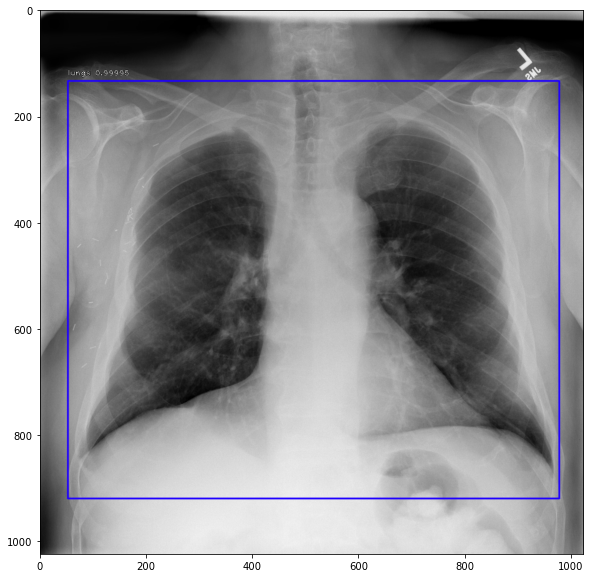

In [16]:
img_file="00000165_001.png"
orig_box=[151,76,939,837]
plt.figure(figsize=(10,10))
predict(img_file,orig_box,model,threshold=1,display=True)